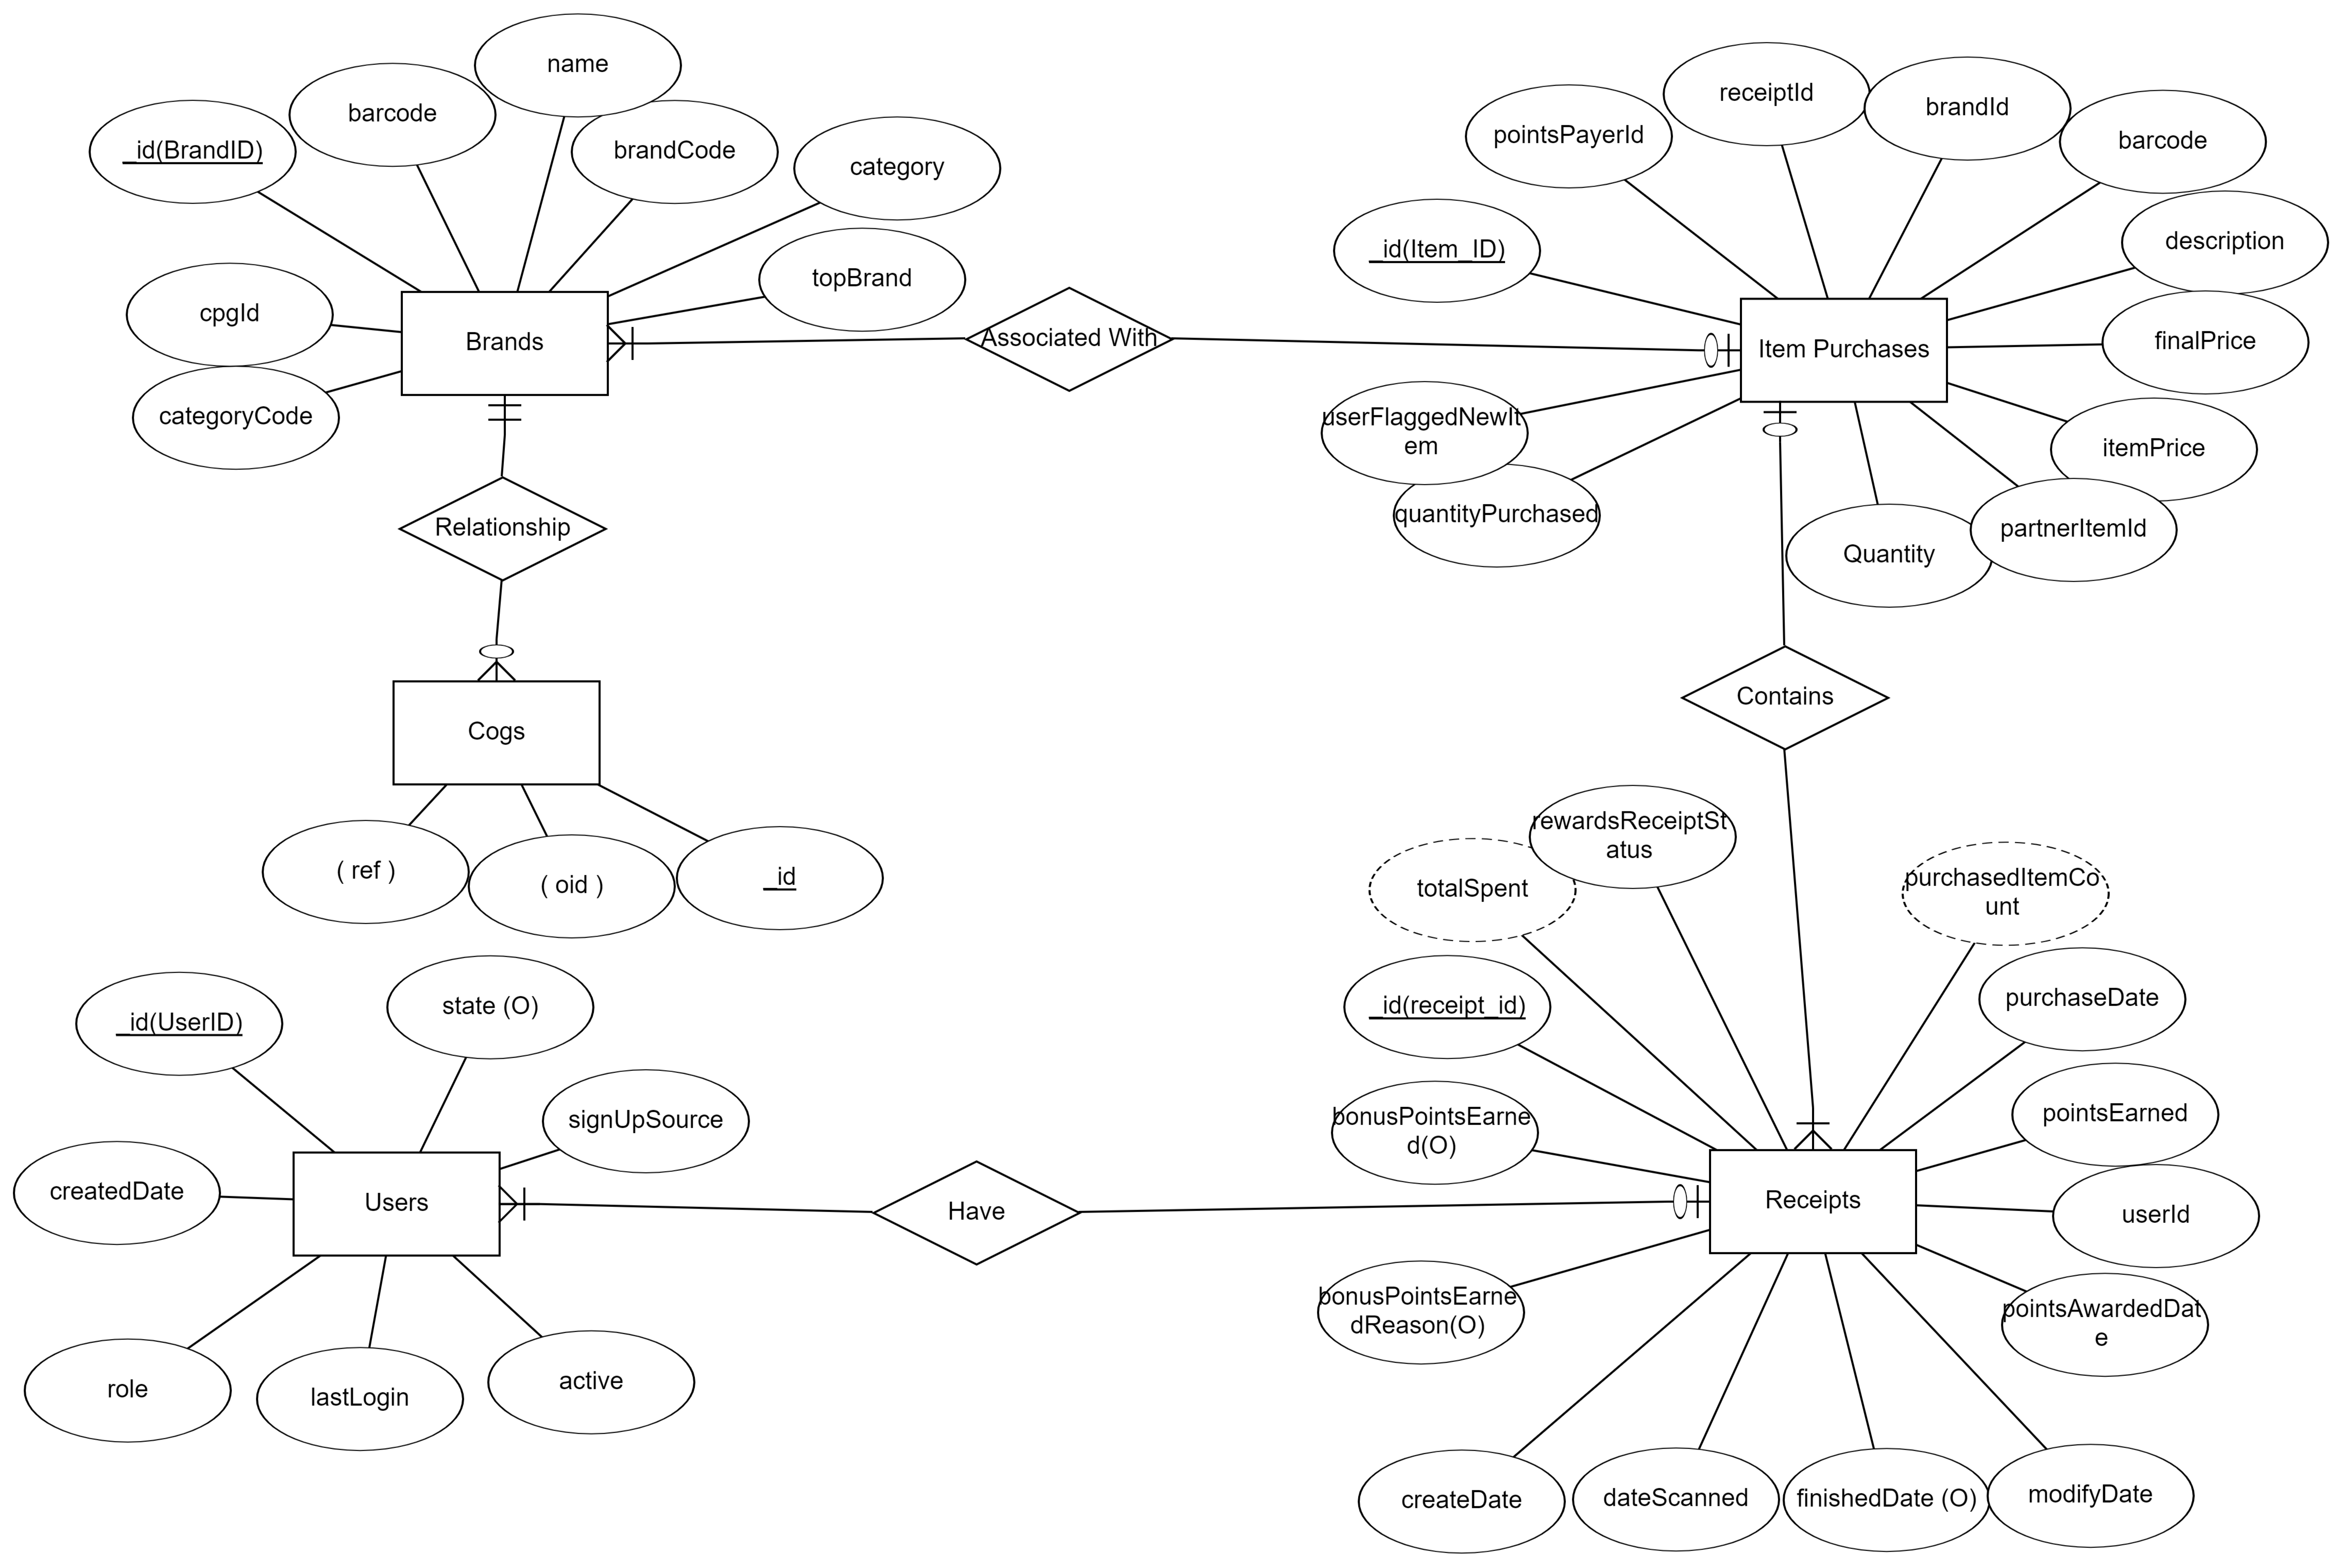

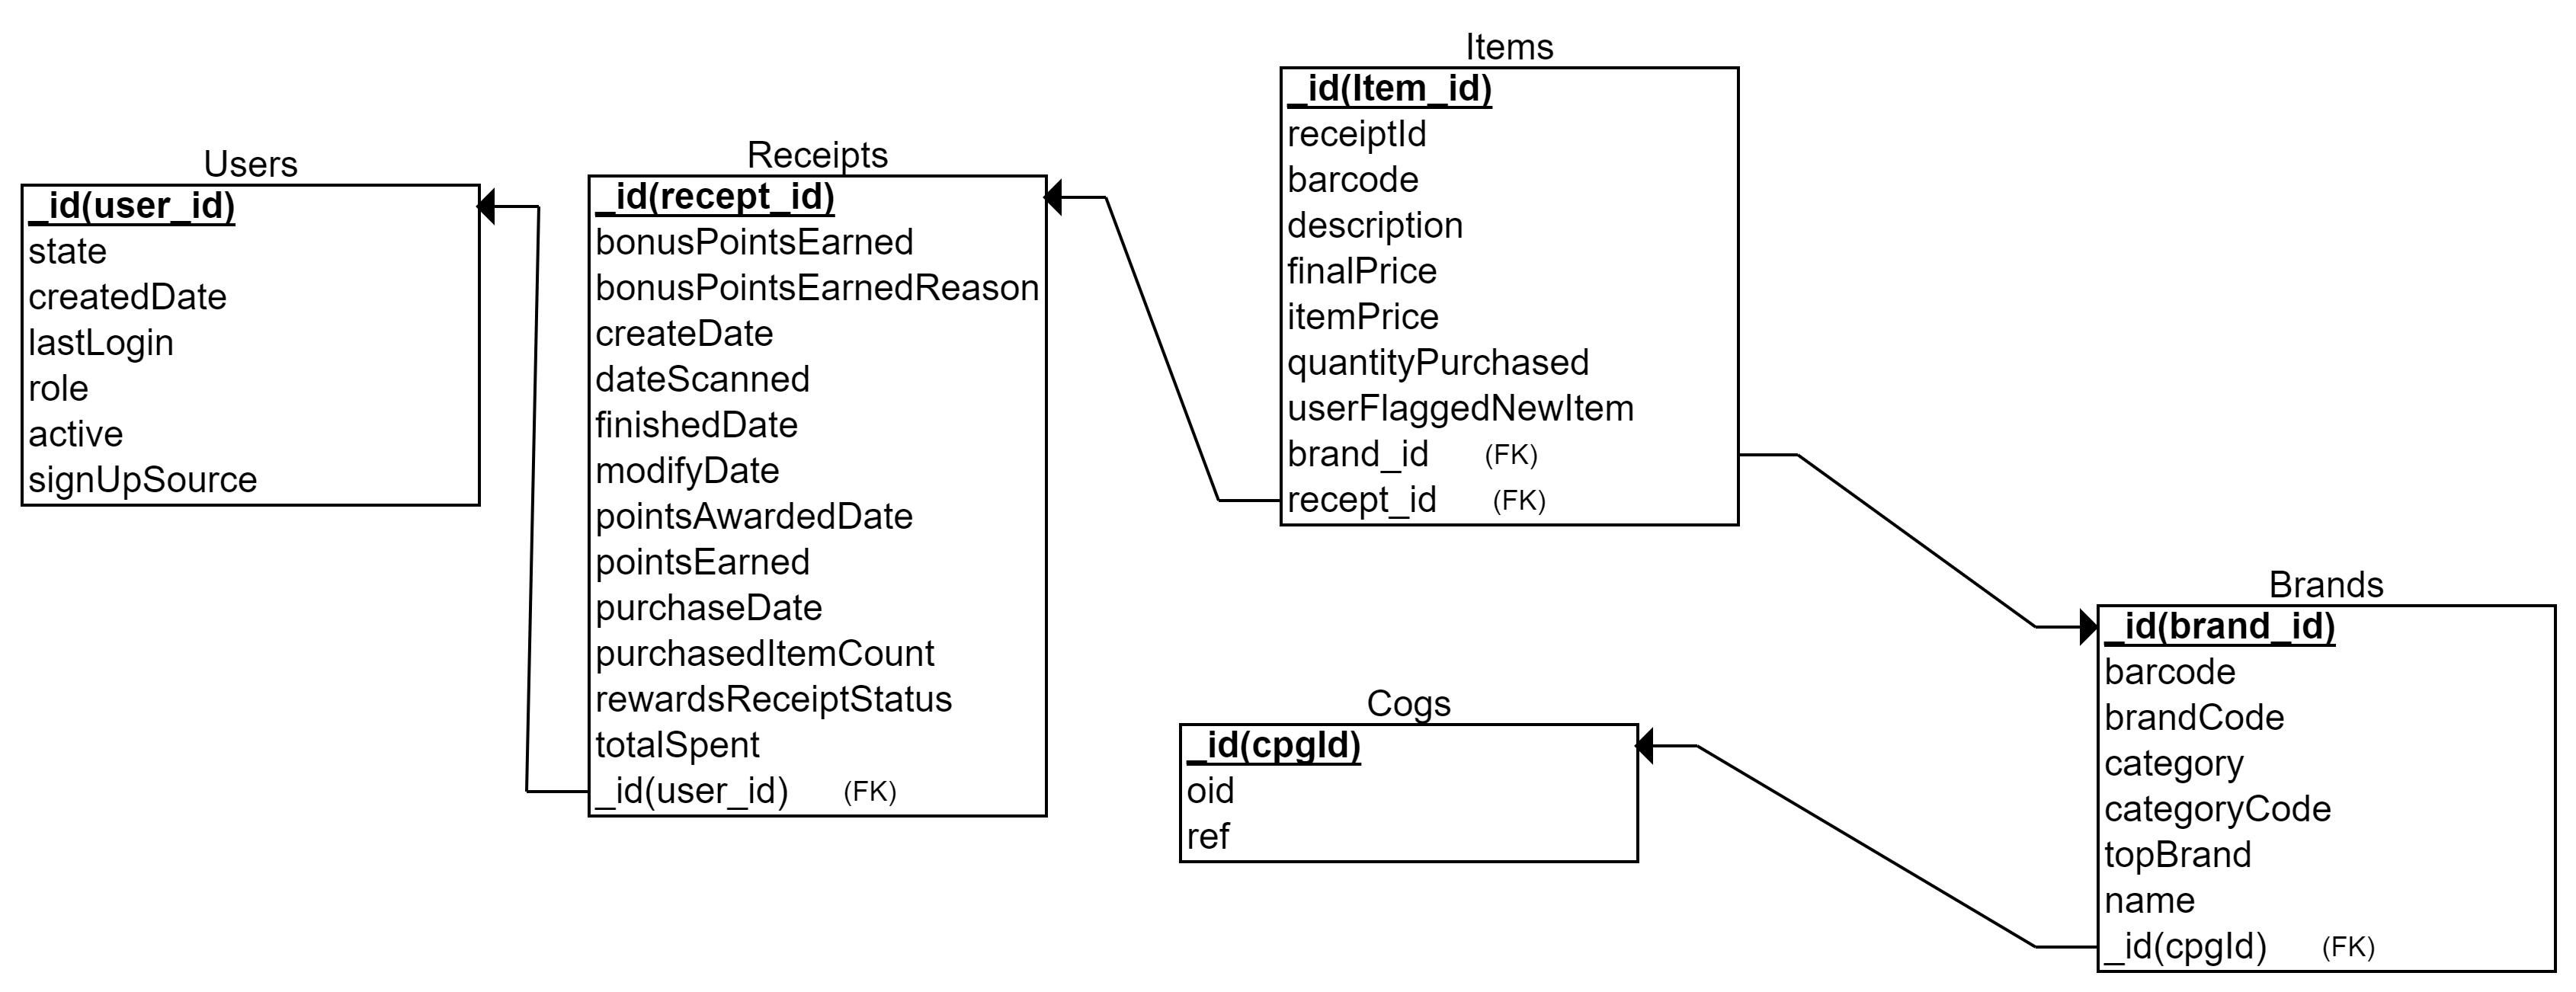

### Part One: Contents of Each Table

The Users table includes a unique person identifier (`_id`), the nation where the consumer resides, the date the person account turned into created, the remaining login date, the consumer function, the lively fame of the consumer account, and the source via which the user signed up. Each consumer must have a completely unique identifier and the relevant information stated to keep consumer-particular statistics accurately.

The Receipts desk consists of a unique receipt identifier (`_id`), the wide variety of bonus points earned, the motive for earning bonus points, the date the receipt turned into created, the date it became scanned, the date the receipt processing finished, the date it became final changed, the date points had been awarded, the range of factors earned, the date of purchase, the remember of bought items, the repute of the receipt, the total quantity spent, and a foreign key (`userId`) referencing the Users desk. This guarantees every receipt is related to a person and carries designated transaction data.

The Items table includes a unique object identifier (`_id`), a foreign key (`receiptId`) referencing the Receipts table, the barcode of the object, a description of the object, the final charge paid, the object’s unique price, the amount bought, a flag indicating if the object became newly flagged by the consumer, and a foreign key (`brandId`) referencing the Brands desk. This desk captures distinct information about every item purchased in a transaction and its association with receipts and types.

The Brands table consists of a completely unique logo identifier (`_id`), the barcode related to the logo, the logo code, the class of products the logo sells, the category code, a foreign key (`cpgId`) referencing the Cogs desk, a trademark if the brand is a top emblem, and the call of the brand. Each brand is uniquely diagnosed and classified, ensuring prepared brand-particular statistics.

The Cogs table includes a completely unique cog identifier (`_id`), a reference characteristic, and an oid attribute. This table serves as a categorization or product grouping entity for brands, imparting a established manner to prepare manufacturers into logical agencies.

### Part Two: Relationships

For every person, the database need to hold music in their precise user identifier, nation, account creation date, remaining login date, function, energetic reputation, and signal-up source. Each consumer need to be related to at the least one receipt, but may be associated with many. Each receipt have to be related to exactly one person.

Each receipt ought to incorporate a unique receipt identifier, information about bonus points earned, the motive for incomes them, introduction date, scan date, finished date, amendment date, factors presented date, factors earned, purchase date, purchased item rely, receipt popularity, total amount spent, and a user identifier referencing the Users desk. Each receipt need to include at the least one item, however can include many. Each item must be related to precisely one receipt.

Each object must consist of a completely unique item identifier, receipt identifier referencing the Receipts table, barcode, description, very last fee, unique charge, quantity bought, a flag indicating if it changed into newly flagged by using the consumer, and a brand identifier referencing the Brands table. Each object should be related to precisely one brand, and every logo could have more than one items related to it.

Each logo must include a completely unique logo identifier, barcode, logo code, class, category code, cog identifier referencing the Cogs desk, pinnacle logo indicator, and logo call. Each emblem must be associated with precisely one cog, and each cog can have a couple of manufacturers related to it.

Each cog must have a unique identifier, reference characteristic, and oid attribute. This desk enables in categorizing and organizing brands into logical companies, making sure that every emblem is part of a broader class or product organization.

## 1. Review Data

In [19]:
import pandas as pd
import gzip
import json

# Load and inspect the data from the JSON files
def load_json_gz(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        return [json.loads(line) for line in file]

def clean_and_load_users(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        lines = file.readlines()
    
    # Extract valid JSON lines
    json_lines = [line for line in lines if line.strip().startswith('{') and line.strip().endswith('}')]
    
    # Load JSON lines
    return [json.loads(line) for line in json_lines]

# Function to convert nested dictionaries to pandas datetime
def extract_datetime(val):
    return pd.to_datetime(val['$date'], unit='ms') if isinstance(val, dict) and '$date' in val else None

# Load data using defined functions
brands_data = load_json_gz('brands.json.gz')
receipts_data = load_json_gz('receipts.json.gz')
users_data = clean_and_load_users('users.json.gz')

# Convert lists to pandas DataFrames
brands_df = pd.DataFrame(brands_data)
receipts_df = pd.DataFrame(receipts_data)
users_df = pd.DataFrame(users_data)

# Extract 'cpg' details and clean '_id' fields in brands_df
if 'cpg' in brands_df.columns:
    brands_df['cpgId'] = brands_df['cpg'].apply(lambda x: x['$id']['$oid'] if isinstance(x, dict) and '$id' in x and '$oid' in x['$id'] else None)
    brands_df.drop(columns=['cpg'], inplace=True)
brands_df['_id'] = brands_df['_id'].apply(lambda x: x['$oid'] if isinstance(x, dict) else x)

# Clean '_id' and date fields in receipts_df
receipts_df['_id'] = receipts_df['_id'].apply(lambda x: x['$oid'] if isinstance(x, dict) else x)
date_fields = ['createDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate', 'purchaseDate']
for field in date_fields:
    receipts_df[field] = receipts_df[field].apply(extract_datetime)

# Extract items from 'rewardsReceiptItemList' if present
if 'rewardsReceiptItemList' in receipts_df.columns:
    items_list = [
        {**item, 'receiptId': row['_id']}
        for _, row in receipts_df.iterrows() if isinstance(row['rewardsReceiptItemList'], list)
        for item in row['rewardsReceiptItemList']
    ]
    items_df = pd.DataFrame(items_list)
    items_df['_id'] = items_df.apply(lambda x: f"{x['receiptId']}_{x['partnerItemId']}", axis=1)
else:
    items_df = pd.DataFrame()

# Assuming 'brandCode' exists in both items_df and brands_df and is the linking attribute.
if 'brandCode' in items_df.columns and 'brandCode' in brands_df.columns:
    # Create a dictionary to map brandCode to brandId from brands_df
    brand_code_to_id = dict(zip(brands_df['brandCode'], brands_df['_id']))

    # Map brandCode to brandId in items_df
    items_df['brandId'] = items_df['brandCode'].map(brand_code_to_id)

    # Check for any items that didn't receive a brandId due to no matching brandCode
    missing_brand_ids = items_df['brandId'].isnull().sum()
    print(f"Items without a matching brandId: {missing_brand_ids}")
else:
    print("brandCode column is missing in items_df or brands_df and is needed for mapping.")
                                     
                                     
# Clean '_id' and date fields in users_df
users_df['_id'] = users_df['_id'].apply(lambda x: x['$oid'] if isinstance(x, dict) else x)
users_df['createdDate'] = users_df['createdDate'].apply(extract_datetime)
users_df['lastLogin'] = users_df['lastLogin'].apply(extract_datetime)

# Remove the 'rewardsReceiptItemList' column from receipts_df
receipts_df.drop(columns=['rewardsReceiptItemList'], inplace=True)

# Display the first few rows of the cleaned dataframes for verification
print("Brands DataFrame:")
print(brands_df.head())
print("\nReceipts DataFrame:")
print(receipts_df.head())
print("\nUsers DataFrame:")
print(users_df.head())
print("\nItems DataFrame:")
print(items_df.head())


Items without a matching brandId: 1971
Brands DataFrame:
                        _id       barcode        category      categoryCode  \
0  601ac115be37ce2ead437551  511111019862          Baking            BAKING   
1  601c5460be37ce2ead43755f  511111519928       Beverages         BEVERAGES   
2  601ac142be37ce2ead43755d  511111819905          Baking            BAKING   
3  601ac142be37ce2ead43755a  511111519874          Baking            BAKING   
4  601ac142be37ce2ead43755e  511111319917  Candy & Sweets  CANDY_AND_SWEETS   

                        name topBrand                      brandCode  \
0  test brand @1612366101024    False                            NaN   
1                  Starbucks    False                      STARBUCKS   
2  test brand @1612366146176    False  TEST BRANDCODE @1612366146176   
3  test brand @1612366146051    False  TEST BRANDCODE @1612366146051   
4  test brand @1612366146827    False  TEST BRANDCODE @1612366146827   

                      cpgId  
0  60

In [37]:
brands_df.to_csv('brands_cleaned.csv', index=False)
receipts_df.to_csv('receipts_cleaned.csv', index=False)
users_df.to_csv('users_cleaned.csv', index=False)
items_df.to_csv('items_cleaned.csv', index=False)



In [13]:
# Map brandCode to brandId in the items DataFrame before uploading to SQL
brand_code_to_id = dict(zip(brands_df['brandCode'], brands_df['_id']))
items_df['brandId'] = items_df['brandCode'].map(brand_code_to_id)


## 2. SQL Queries

In [27]:
items_df = items_df.dropna(subset=['brandId'])

# Re-create the SQLite database connection
conn = sqlite3.connect(':memory:')

brands_df.to_sql('brands', conn, index=False, if_exists='append')
receipts_df.to_sql('receipts', conn, index=False, if_exists='append')
items_df.to_sql('items', conn, index=False, if_exists='append')
users_df.to_sql('users', conn, index=False, if_exists='append')

query = """
SELECT b.name AS BrandName, COUNT(DISTINCT r._id) AS ReceiptsCount
FROM receipts r
JOIN items i ON r._id = i.receiptId
JOIN brands b ON i.brandId = b._id
WHERE r.dateScanned >= '2021-01-01'
AND r.dateScanned < '2021-02-01'
GROUP BY b.name
ORDER BY ReceiptsCount DESC
LIMIT 5;
"""

top_brands = pd.read_sql_query(query, conn)
print(top_brands)


                   BrandName  ReceiptsCount
0  test brand @1601644365844            504
1                      Pepsi             23
2                      Kraft             22
3                    Kleenex             21
4                    Doritos             19


In [29]:
query = """
SELECT b.name AS BrandName, SUM(r.totalSpent) AS TotalSpent
FROM receipts r
JOIN users u ON r.userId = u._id
JOIN items i ON r._id = i.receiptId
JOIN brands b ON i.brandId = b._id
WHERE u.createdDate >= '2021-01-01' -- Adjust this date based on your latest user date
GROUP BY b.name
ORDER BY TotalSpent DESC
LIMIT 1;
"""
top_brand = pd.read_sql_query(query, conn)
print(top_brand)


                   BrandName  TotalSpent
0  test brand @1601644365844  3789004.29


### 1. Missing value

In [38]:
# Calculate the percentage of missing values for each column in each DataFrame
missing_values_items = items_df.isnull().mean() * 100
missing_values_receipts = receipts_df.isnull().mean() * 100
missing_values_users = users_df.isnull().mean() * 100
missing_values_brands = brands_df.isnull().mean() * 100

# Combine into a single DataFrame for better visualization
missing_data_summary = pd.DataFrame({
    'Items': missing_values_items,
    'Receipts': missing_values_receipts,
    'Users': missing_values_users,
    'Brands': missing_values_brands
})

# Display the DataFrame with missing data percentages
missing_data_summary


,Items,Receipts,Users,Brands
_id,0.000000,0.000000,0.000000,0.000000
active,NaN,NaN,0.000000,NaN
barcode,60.623742,NaN,NaN,0.000000
bonusPointsEarned,NaN,51.385165,NaN,NaN
bonusPointsEarnedReason,NaN,51.385165,NaN,NaN
brandCode,87.344064,NaN,NaN,20.051414
brandId,0.000000,NaN,NaN,NaN
category,NaN,NaN,NaN,13.281919
categoryCode,NaN,NaN,NaN,55.698372
competitiveProduct,92.152918,NaN,NaN,NaN


### 2. Check Duplicates

In [39]:
# Check for duplicate records in each dataset
duplicates_items = items_df.duplicated().sum()
duplicates_receipts = receipts_df.duplicated().sum()
duplicates_users = users_df.duplicated().sum()
duplicates_brands = brands_df.duplicated().sum()

# Check for duplicate keys where '_id' should be unique
duplicate_ids_items = items_df['_id'].duplicated().sum()
duplicate_ids_receipts = receipts_df['_id'].duplicated().sum()
duplicate_ids_users = users_df['_id'].duplicated().sum()
duplicate_ids_brands = brands_df['_id'].duplicated().sum()

# Compile the results into a dictionary for better visualization
duplicate_summary = {
    'Dataset': ['Items', 'Receipts', 'Users', 'Brands'],
    'Duplicate Records': [duplicates_items, duplicates_receipts, duplicates_users, duplicates_brands],
    'Duplicate IDs': [duplicate_ids_items, duplicate_ids_receipts, duplicate_ids_users, duplicate_ids_brands]
}

pd.DataFrame(duplicate_summary)


,Dataset,Duplicate Records,Duplicate IDs
0,Items,0,0
1,Receipts,0,0
2,Users,282,282
3,Brands,0,0


### 3. Invalid or inconsistent data

In [42]:
# Convert 'finalPrice' to numeric
items_df['finalPrice'] = pd.to_numeric(items_df['finalPrice'], errors='coerce')

# Now you can safely check for negative values
print('Negative prices in items:', (items_df['finalPrice'] < 0).sum())
users_df['createdDate'] = pd.to_datetime(users_df['createdDate'], errors='coerce')
users_df['lastLogin'] = pd.to_datetime(users_df['lastLogin'], errors='coerce')
receipts_df['createDate'] = pd.to_datetime(receipts_df['createDate'], errors='coerce')

# Check for negative values in fields where it doesn't make sense
print('Negative prices in items:', (items_df['finalPrice'] < 0).sum())

# Standardize categorical data
users_df['role'] = users_df['role'].str.lower()
brands_df['category'] = brands_df['category'].str.title()  # Capitalize each word

# Validate barcodes are numeric (example)
items_df['barcode'] = pd.to_numeric(items_df['barcode'], errors='coerce')


Negative prices in items: 0
Negative prices in items: 0


In [43]:
# Check for unique values in categorical fields to spot inconsistencies
print("Unique roles:", users_df['role'].unique())
print("Unique states:", users_df['state'].unique())

Unique roles: ['consumer' 'fetch-staff']
Unique states: ['WI' 'KY' 'AL' 'CO' 'IL' nan 'OH' 'SC' 'NH']


In [44]:
# cleaning and checking the 'name' field in the brands dataset
brands_df['name'] = brands_df['name'].str.strip().str.title()  # Normalize case and remove extra spaces
print("Cleaned unique brand names:", brands_df['name'].unique())


Cleaned unique brand names: ['Test Brand @1612366101024' 'Starbucks' 'Test Brand @1612366146176' ...
 'Test Brand @1598639215217' 'Lipton Tea Leaves'
 'Test Brand @1613158231643']


In [45]:
Q1 = items_df['finalPrice'].quantile(0.25)
Q3 = items_df['finalPrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = items_df[(items_df['finalPrice'] < lower_bound) | (items_df['finalPrice'] > upper_bound)]
print("Outliers in finalPrice:", outliers)


Outliers in finalPrice:            barcode                                        description  \
0     4.011000e+03                                     ITEM NOT FOUND   
4     4.011000e+03                                     ITEM NOT FOUND   
13    1.356230e+10  Annie's Homegrown Organic White Cheddar Macaro...   
14    3.410057e+10                       MILLER LITE 24 PACK 12OZ CAN   
15    3.410057e+10                       MILLER LITE 24 PACK 12OZ CAN   
...            ...                                                ...   
6931           NaN  mueller austria hypergrind precision electric ...   
6933           NaN  mueller austria hypergrind precision electric ...   
6935           NaN  mueller austria hypergrind precision electric ...   
6937           NaN  mueller austria hypergrind precision electric ...   
6939           NaN  mueller austria hypergrind precision electric ...   

      finalPrice itemPrice needsFetchReview partnerItemId  \
0          26.00     26.00            

In [46]:
# Check for invalid characters in an ID field
users_df['_id'] = users_df['_id'].astype(str)  # Ensure ID is treated as a string
users_df['invalid_id'] = users_df['_id'].apply(lambda x: not x.isalnum())  # Check for non-alphanumeric IDs
print("Invalid IDs found:", users_df[users_df['invalid_id']])


Invalid IDs found: Empty DataFrame
Columns: [_id, active, createdDate, lastLogin, role, signUpSource, state, invalid_id]
Index: []


### 4.Value distributions and outliers

In [47]:
# Numerical Data
print(items_df['finalPrice'].describe())


import matplotlib.pyplot as plt
items_df['finalPrice'].hist(bins=50)
plt.title('Distribution of Final Prices')
plt.xlabel('Final Price')
plt.ylabel('Frequency')
plt.show()


count    4796.000000
mean        8.183649
std        14.889488
min         0.000000
25%         2.230000
50%         4.630000
75%         9.990000
max       441.580000
Name: finalPrice, dtype: float64


<Figure size 640x480 with 1 Axes>

WI    395
NH     20
AL     12
OH      5
IL      3
KY      1
CO      1
SC      1
Name: state, dtype: int64


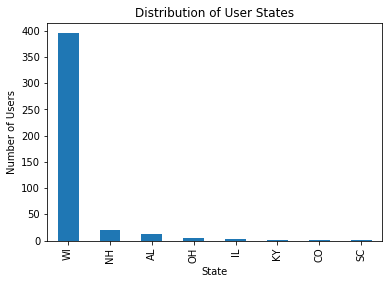

In [48]:
# Value counts
print(users_df['state'].value_counts())

# Bar chart for visualizing the distribution
users_df['state'].value_counts().plot(kind='bar')
plt.title('Distribution of User States')
plt.xlabel('State')
plt.ylabel('Number of Users')
plt.show()


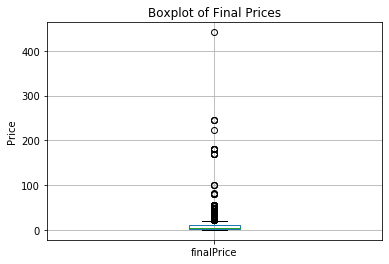

In [49]:
# Boxplot for 'finalPrice'
items_df.boxplot(column='finalPrice')
plt.title('Boxplot of Final Prices')
plt.ylabel('Price')
plt.show()


In [50]:
import numpy as np

# Calculate Z-scores of `finalPrice`
items_df['z_score_finalPrice'] = (items_df['finalPrice'] - items_df['finalPrice'].mean()) / items_df['finalPrice'].std()
outliers_z = items_df[np.abs(items_df['z_score_finalPrice']) > 3]
print("Outliers based on Z-score:", outliers_z)


Outliers based on Z-score:            barcode                   description  finalPrice itemPrice  \
4540           NaN  DOLE PINEAPPLE CHUNKS IN 10C      441.58    441.58   
4544           NaN    FELINEGREENIES ADULT DENTA       82.34     82.34   
4723           NaN                     CRCKR BRL      168.84    168.84   
4724           NaN                     Chestnuts      180.00    180.00   
4917           NaN               Sparkling Peach       80.00     80.00   
4938           NaN                    PAGASA PAS       54.91     54.91   
4981           NaN                    GRAPE RASP      245.00    245.00   
5044           NaN                   SPAPKLING 1      100.00    100.00   
5074           NaN                   MOUNTAIN DE       53.97     53.97   
5098           NaN                     CRCKR BRL      168.84    168.84   
5099           NaN                     Chestnuts      180.00    180.00   
5102           NaN                     CRCKR BRL      168.84    168.84   
5103       

﻿Based at the special exams and analysis of your datasets, here is a summary of the information high-quality troubles recognized:

### 1. Missing Values
Several fields across all datasets have huge probabilities of missing values. Notable columns with high chances of missing values consist of:
- **Items Data**: `barcode` (60.Sixty two%), `brandCode` (87.34%), `competitiveProduct` (92.15%), `competitorRewardsGroup` (100%), `deleted` (99.82%), `originalMetaBriteBarcode` (ninety eight.57%), and several others.
- **Receipts Data**: `bonusPointsEarned` (fifty one.39%), `bonusPointsEarnedReason` (fifty one.39%), `finishedDate` (forty nine.24%), `pointsAwardedDate` (52.01%), `purchaseDate` (40.04%), `purchasedItemCount` (43.25%), and others.
- **Users Data**: `lastLogin` (12.Fifty five%), `signUpSource` (nine.Seventy two%), `nation` (eleven.34%).
- **Brands Data**: `class` (13.28%), `categoryCode` (fifty five.70%), `topBrand` (fifty two.44%).

### 2. Duplicates
- **Users Data**: 282 replica records and replica IDs were found, indicating ability issues with information access or processing.

### 3. Invalid or Inconsistent Data Formats
- **Numerical Data Issues**: `finalPrice` in `items_df` needed to be coerced to numeric, indicating that a few entries were not to start with in a valid numeric format.
- **Date Formats**: Date fields in `users_df` and `receipts_df` wished conversion to datetime format, suggesting inconsistencies in how dates had been saved.
- **Categorical Data Consistency**: Inconsistent casing and formatting in express fields like `position` in `users_df` and `class` in `brands_df`.

### 4. Value Distributions and Outliers
- **Outliers**: Significant outliers have been identified inside the `finalPrice` column of `items_df`. For example, expenses like $441.Fifty eight, $82.34, and $168.84, which might be surprisingly excessive as compared to the standard variety of values.
- **State Distributions**: Some states in `users_df` have very few entries, which might imply information sparsity problems or potential errors in country recording.
